In [1]:
# ComplEx embeddings :

hidden_channels = 176
batch_size = 4096
epochs = 1000
file_path = "/home/elliot/Desktop/StageM2/data/iric/little_iric.tsv"

# Losses tests :

n_negative_triplets_per_positive = 4 # Number of false negatives triples per positive triple in the dataset for losses tests.

# Imports, install and mount

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# %pwd
# print("DRIVE MOUNTED")

In [3]:
! pip install cuda
! pip install torch_geometric
! pip install dgl

import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import dgl
import os
from torch.nn.functional import normalize


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cuda (from versions: none)
ERROR: No matching distribution found for cuda
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/elliot/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # Tip : Use cpu for debugging
print(device)

cuda


# Preparing ComplEx embeddings

## TSV to pyg.Data

We want :
- x (tensorised and processed node attributes) (1 for now)
- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
- edge_attr (a tensor that indicate the type of each edge)
- y (edge labels - optional, can be defined as node labels if needed)

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [5]:
iric = pd.read_csv(file_path, delimiter='\t')
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: i for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: i for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)


print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}
print(mapping_to_entity)
print(mapping_to_relation)

,subject,predicate,object
0,GO:0000001,is_a,GO:0048311
1,GO:0000001,is_a,GO:0048308
2,GO:0000002,is_a,GO:0007005
3,GO:0000003,is_a,GO:0008150
4,GO:0000006,is_a,GO:0005385
...,...,...,...
9994,GO:0009920,is_a,GO:0000919
9995,GO:0009920,is_a,GO:1903047
9996,GO:0009921,is_a,GO:0098797
9997,GO:0009922,is_a,GO:0016747


,subject,predicate,object
0,3323,0,7983
1,3323,0,751
2,3333,0,2184
3,7657,0,4103
4,293,0,681
...,...,...,...
9994,3400,0,2008
9995,3400,0,1807
9996,8348,0,6570
9997,8255,0,3617


Minima in mappings :
subject : 0
predicate : 0
object : 4
{'GO:0009007': 0, 'GO:0001504': 1, 'GO:0006548': 2, 'GO:0001402': 3, 'GO:0003339': 4, 'GO:0007041': 5, 'GO:0002517': 6, 'GO:0040001': 7, 'GO:0002909': 8, 'GO:1903173': 9, 'GO:0015172': 10, 'GO:0003286': 11, 'GO:0001825': 12, 'GO:0009427': 13, 'GO:0009886': 14, 'GO:0000127': 15, 'GO:0001709': 16, 'GO:0007076': 17, 'GO:0002896': 18, 'GO:0004578': 19, 'GO:0008308': 20, 'GO:0004990': 21, 'GO:0008227': 22, 'GO:0005628': 23, 'GO:0001652': 24, 'GO:0008356': 25, 'GO:0006421': 26, 'GO:0071917': 27, 'GO:0004579': 28, 'GO:0003246': 29, 'GO:0008900': 30, 'GO:0000196': 31, 'GO:0046649': 32, 'GO:0110156': 33, 'GO:0001730': 34, 'GO:0005840': 35, 'GO:0002541': 36, 'GO:0002878': 37, 'GO:0005200': 38, 'GO:0043043': 39, 'GO:0008926': 40, 'GO:0042756': 41, 'GO:0048285': 42, 'GO:0003066': 43, 'GO:0005743': 44, 'GO:0009164': 45, 'GO:0002571': 46, 'GO:0046095': 47, 'GO:0035588': 48, 'GO:0016837': 49, 'GO:0017004': 50, 'GO:0010459': 51, 'GO:0005801': 5

## Building init vars for Data :

In [6]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[3323, 3323, 3333,  ..., 8348, 8255, 3512],
        [7983,  751, 2184,  ..., 6570, 3617, 3248]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Dataset looks valid ? 
 True


## Setting up datas and model


## Splitting dataset

In [7]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9000], edge_attr=[9000], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])
Number of edges in datasets : 
  Train: 8001

  Test : 1998

  Validation : 1998




 8859
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[ 589, 3182, 1556,  ..., 1753, 1554, 7740],
        [5819, 6420,   14,  ..., 7432, 1723, 6781]], device='cuda:0'), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'), 'num_nodes': 8859, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'), 'edge_label_index': tensor([[ 589, 3182, 1556,  ..., 1753, 1554, 7740],
        [5819, 6420,   14,  ..., 7432, 1723, 6781]], device='cuda:0')}}
torch.Size([8001])
torch.Size([8001])
torch.Size([8001])
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
8859
8001


## Iniating model

In [8]:
model = ComplEx(
    num_nodes=train_data.num_nodes,
    # num_relations=train_data.num_edge_types,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
    # neg_sampling = 4
)

optimizer = optim.Adam(model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

## Training and testing ComplEx

In [9]:
@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train():
    model.train()
    total_loss = total_examples = 0

    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

In [10]:
torch.set_grad_enabled(True)
model.to(device)

model.reset_parameters()


start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

  0%|          | 0/9000 [00:00<?, ?it/s]

100%|██████████| 9000/9000 [01:04<00:00, 138.94it/s]


Start Test Mean Rank: 4411.55, Start Test MRR: 0.0010, Start Test Hits@10: 0.0007
Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6931
Epoch: 004, Loss: 0.6931
Epoch: 005, Loss: 0.6930
Epoch: 006, Loss: 0.6930
Epoch: 007, Loss: 0.6929
Epoch: 008, Loss: 0.6928
Epoch: 009, Loss: 0.6928
Epoch: 010, Loss: 0.6927
Epoch: 011, Loss: 0.6925
Epoch: 012, Loss: 0.6924
Epoch: 013, Loss: 0.6922
Epoch: 014, Loss: 0.6921
Epoch: 015, Loss: 0.6918
Epoch: 016, Loss: 0.6916
Epoch: 017, Loss: 0.6913
Epoch: 018, Loss: 0.6909
Epoch: 019, Loss: 0.6905
Epoch: 020, Loss: 0.6901
Epoch: 021, Loss: 0.6895
Epoch: 022, Loss: 0.6889
Epoch: 023, Loss: 0.6882
Epoch: 024, Loss: 0.6875
Epoch: 025, Loss: 0.6866
Epoch: 026, Loss: 0.6856
Epoch: 027, Loss: 0.6845
Epoch: 028, Loss: 0.6833
Epoch: 029, Loss: 0.6819
Epoch: 030, Loss: 0.6804
Epoch: 031, Loss: 0.6788
Epoch: 032, Loss: 0.6770
Epoch: 033, Loss: 0.6750
Epoch: 034, Loss: 0.6727
Epoch: 035, Loss: 0.6704
Epoch: 036, Loss: 0.6678
Epoch: 037, Loss: 

100%|██████████| 9000/9000 [01:10<00:00, 128.17it/s]


Epoch: 500, Val Mean Rank: 546.52 Val MRR: 0.7570, Val Hits@10: 0.9032
Epoch: 501, Loss: 0.0334
Epoch: 502, Loss: 0.0331
Epoch: 503, Loss: 0.0340
Epoch: 504, Loss: 0.0325
Epoch: 505, Loss: 0.0328
Epoch: 506, Loss: 0.0314
Epoch: 507, Loss: 0.0321
Epoch: 508, Loss: 0.0309
Epoch: 509, Loss: 0.0313
Epoch: 510, Loss: 0.0312
Epoch: 511, Loss: 0.0298
Epoch: 512, Loss: 0.0293
Epoch: 513, Loss: 0.0295
Epoch: 514, Loss: 0.0292
Epoch: 515, Loss: 0.0286
Epoch: 516, Loss: 0.0288
Epoch: 517, Loss: 0.0290
Epoch: 518, Loss: 0.0278
Epoch: 519, Loss: 0.0278
Epoch: 520, Loss: 0.0267
Epoch: 521, Loss: 0.0270
Epoch: 522, Loss: 0.0266
Epoch: 523, Loss: 0.0264
Epoch: 524, Loss: 0.0260
Epoch: 525, Loss: 0.0270
Epoch: 526, Loss: 0.0262
Epoch: 527, Loss: 0.0260
Epoch: 528, Loss: 0.0253
Epoch: 529, Loss: 0.0253
Epoch: 530, Loss: 0.0249
Epoch: 531, Loss: 0.0246
Epoch: 532, Loss: 0.0246
Epoch: 533, Loss: 0.0251
Epoch: 534, Loss: 0.0237
Epoch: 535, Loss: 0.0233
Epoch: 536, Loss: 0.0237
Epoch: 537, Loss: 0.0225
Epoc

100%|██████████| 9000/9000 [01:34<00:00, 94.89it/s] 

Start Test Mean Rank: 4411.55, Start Test MRR: 0.0010, Start Test Hits@10: 0.0007
Final Test Mean Rank: 537.49, Final Test MRR: 0.7580, Final Test Hits@10: 0.9053


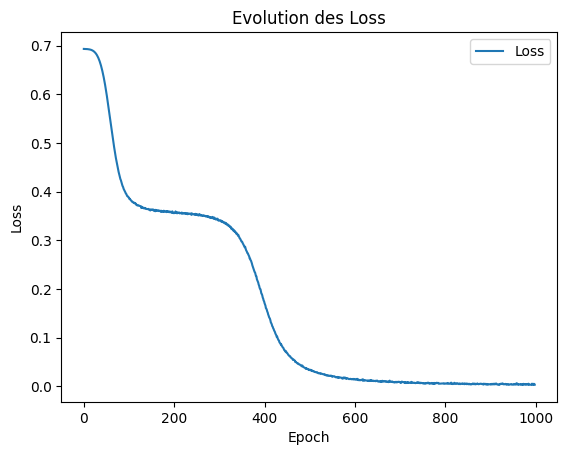

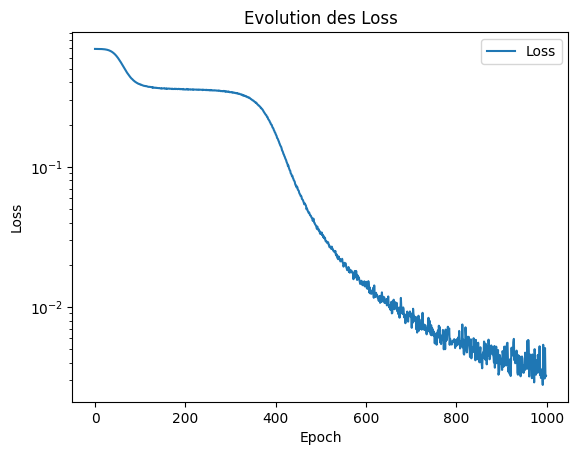

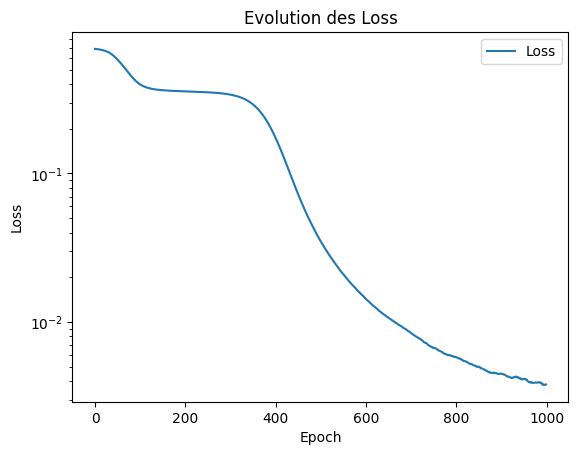

In [11]:
import matplotlib.pyplot as plt
def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider 
                                  # ahead and behind the pos X to calculate running mean at X.
                 ):

    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

plot_loss(losses)
plot_loss_log(losses)
plot_loss_log(running_mean(losses, 30))

## Looking for embeddings

In [12]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Desktop/StageM2/ESL2024/code/TestComplEx


In [13]:
model.to('cpu')
torch.set_grad_enabled(False)

# Is model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))

print("Bad scores should appear here :")
print(model(torch.tensor(3307),torch.tensor(0),torch.tensor(4788)))
print(model(torch.tensor(3307),torch.tensor(0),torch.tensor(4378)))

Good score should appear here :
tensor(6.1998)
Bad scores should appear here :
tensor(-5.5754)
tensor(-5.5352)


Attributs pour accéder aux embeddings :

        head_re = self.node_emb(head_index)
        head_im = self.node_emb_im(head_index)
        rel_re = self.rel_emb(rel_type)
        rel_im = self.rel_emb_im(rel_type)
        tail_re = self.node_emb(tail_index)
        tail_im = self.node_emb_im(tail_index)

In [14]:
entities_mapping_to_embedding = {}
relation_mapping_to_embedding = {}

for entity in entity_set:
    entity_id = entity_to_mapping[entity]

    real_part = model.node_emb(torch.tensor(entity_id))
    im_part = model.node_emb_im(torch.tensor(entity_id))

    embedding = torch.cat((real_part, im_part))

    entities_mapping_to_embedding[entity_id] = embedding


for relation in relation_set:
    relation_id = relation_to_mapping[relation]

    real_part = model.rel_emb(torch.tensor(relation_id))
    im_part = model.rel_emb_im(torch.tensor(relation_id))

    embedding = torch.cat((real_part, im_part))

    relation_mapping_to_embedding[relation_id] = embedding

In [15]:
print(relation_mapping_to_embedding[0])
print(entities_mapping_to_embedding[0])

tensor([-0.9785, -0.7775, -1.5046, -0.8002,  0.6947, -1.3738,  0.6832,  0.6765,
        -1.1835,  0.6947, -1.4157,  0.7058, -1.4279,  0.7024,  0.6889, -1.3539,
        -1.3686,  0.6872, -0.9097,  0.6808, -1.0333,  0.6821,  0.6863, -1.4641,
         0.6986,  0.6996,  0.7009,  0.6918, -0.7096, -1.1858,  0.6947, -1.5618,
        -1.0335, -0.8959, -0.8487, -0.8802, -0.8393, -1.0852,  0.7085, -1.5884,
        -0.8351, -1.4999, -1.3310,  0.6837, -0.9823,  0.6902,  0.6969,  0.7232,
         0.6957, -0.8082,  0.6821, -1.3026,  0.6917, -1.1816,  0.6951, -1.3427,
        -1.3422, -0.7927,  0.6867, -1.0279, -1.4231,  0.6886,  0.6870,  0.7011,
         0.6812, -1.1550, -1.0572, -0.9373, -0.9695, -0.9299, -1.5746,  0.6830,
        -1.1432,  0.6879, -0.7392, -1.4296,  0.6840,  0.6822,  0.7338, -1.2600,
         0.6776,  0.7099,  0.6924, -0.8360,  0.6900,  0.6936,  0.6889, -0.8247,
        -1.2213,  0.7078, -1.0212,  0.6884, -1.4379,  0.6742,  0.7045,  0.6976,
         0.7041, -1.2079, -1.2152, -1.37

# Preparing a dataset to investigate modified loss

## Making negative triples

On va créer n triplets négatifs par triplet positif.
Pour créer un triplet négatif à partir d'un triplet positif, on remplace la tête de ce dernier par une entité aléatoire.
Il y a une chance de créer des faux négatifs, mais comme chaque entité apparait moins d'une fois sur 1000 dans le jeu de données, cette probabilité reste faible.

In [16]:
# Nombre de triplets négatif par triplet positif :
n_negative_triplets_per_positive = 5

In [17]:
# Nombre d'apparition de chaque entité dans iric :
# mapped_iric.hist(column="subject", bins = len(list(entity_set)))

In [18]:
import numpy as np
from tqdm import tqdm
import random

def generate_negative_triples(df, number_of_false_per_true, falsify_relation = False):


    negative_triples = []

    possible_heads = list(set(list(df.iloc[:,0])))
    possible_relations = list(set(list(df.iloc[:,1])))
    possible_tails = list(set(list(df.iloc[:,2])))

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Negative Triples"):
        for i in range(number_of_false_per_true):

            if falsify_relation :
                r = np.random.randint(2) 
            else :
                r = np.random.randint(3)

            if r == 0:
                random_head = random.choice(possible_heads)
                negative_triples.append([random_head, row[1], row[2]])

            elif r == 1:
                random_tail = random.choice(possible_tails)
                negative_triples.append([row[0], row[1], random_tail])

            elif r == 2:
                random_relation = random.choice(possible_relations)
                negative_triples.append([row[0], random_relation, row[2]])
                
    negative_triples_df = pd.DataFrame(negative_triples, columns=df.columns)
    return pd.DataFrame(negative_triples_df)

negatives_from_iric = generate_negative_triples(mapped_iric, n_negative_triplets_per_positive)

display(mapped_iric)
display(negatives_from_iric)

Generating Negative Triples:   0%|          | 0/9999 [00:00<?, ?it/s]/tmp/ipykernel_49623/1758883856.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([row[0], row[1], random_tail])
/tmp/ipykernel_49623/1758883856.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([row[0], random_relation, row[2]])
/tmp/ipykernel_49623/1758883856.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Generating Negative Triples: 100%|██████████| 9999/9999 [00:03<00:00, 3167.12it/s]


,subject,predicate,object
0,3323,0,7983
1,3323,0,751
2,3333,0,2184
3,7657,0,4103
4,293,0,681
...,...,...,...
9994,3400,0,2008
9995,3400,0,1807
9996,8348,0,6570
9997,8255,0,3617


,subject,predicate,object
0,3323,0,6494
1,3323,0,1130
2,3323,0,7983
3,3323,0,7983
4,3323,0,7983
...,...,...,...
49990,888,0,3248
49991,3512,0,2833
49992,3512,0,1040
49993,1529,0,3248


In [19]:
labelled_mapped_iric = mapped_iric.copy()
labelled_mapped_iric['label']=1
labelled_negatives_from_iric = negatives_from_iric.copy()
labelled_negatives_from_iric['label']=0
mapped_iric_with_negatives = pd.concat([labelled_mapped_iric, labelled_negatives_from_iric])
display(mapped_iric_with_negatives)

,subject,predicate,object,label
0,3323,0,7983,1
1,3323,0,751,1
2,3333,0,2184,1
3,7657,0,4103,1
4,293,0,681,1
...,...,...,...,...
49990,888,0,3248,0
49991,3512,0,2833,0
49992,3512,0,1040,0
49993,1529,0,3248,0


In [20]:
shuffled_mapped_iric_with_negatives = mapped_iric_with_negatives.sample(frac=1).reset_index(drop=True)
display(shuffled_mapped_iric_with_negatives)

,subject,predicate,object,label
0,4271,0,2861,0
1,6874,0,2979,0
2,1600,0,176,0
3,7622,0,7981,0
4,2632,0,2627,0
...,...,...,...,...
59989,6364,0,2940,0
59990,546,0,7662,0
59991,7868,0,4157,0
59992,2368,0,6695,0


## From mapping to embedding

In [21]:
display(shuffled_mapped_iric_with_negatives)

tensorized_triples = shuffled_mapped_iric_with_negatives.copy()
tensorized_triples['object'] = tensorized_triples['object'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['subject'] = tensorized_triples['subject'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['predicate'] = tensorized_triples['predicate'].apply(lambda x: relation_mapping_to_embedding[x])
display(tensorized_triples)

,subject,predicate,object,label
0,4271,0,2861,0
1,6874,0,2979,0
2,1600,0,176,0
3,7622,0,7981,0
4,2632,0,2627,0
...,...,...,...,...
59989,6364,0,2940,0
59990,546,0,7662,0
59991,7868,0,4157,0
59992,2368,0,6695,0


,subject,predicate,object,label
0,"[tensor(0.3631), tensor(-0.1772), tensor(0.046...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(0.1243), tensor(0.3653), tensor(0.0697...",0
1,"[tensor(0.0766), tensor(0.0896), tensor(0.1853...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(-0.0252), tensor(0.2668), tensor(0.216...",0
2,"[tensor(0.1126), tensor(0.0916), tensor(0.1239...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(0.1668), tensor(0.1132), tensor(0.4131...",0
3,"[tensor(0.3444), tensor(0.3540), tensor(0.4577...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(-0.0477), tensor(-0.0729), tensor(-0.0...",0
4,"[tensor(0.2540), tensor(0.2017), tensor(-0.146...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(0.1819), tensor(0.0450), tensor(0.5925...",0
...,...,...,...,...
59989,"[tensor(0.3945), tensor(-0.0305), tensor(-0.10...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(-0.0353), tensor(-0.1441), tensor(0.35...",0
59990,"[tensor(0.2867), tensor(-0.1341), tensor(0.509...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(0.2963), tensor(-0.2185), tensor(0.217...",0
59991,"[tensor(0.1637), tensor(0.0054), tensor(-0.102...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(0.2755), tensor(0.1791), tensor(-0.034...",0
59992,"[tensor(-0.2081), tensor(-0.2157), tensor(0.13...","[tensor(-0.9785), tensor(-0.7775), tensor(-1.5...","[tensor(-0.1463), tensor(0.1666), tensor(0.026...",0


## Normalizing and merging triples

In [22]:
def normalize_tensor(x):
    try :
        return normalize(torch.tensor(x), dim=-1,eps=0.000001).clone().detach().requires_grad_(False)
    except :
        raise ValueError(f"Could not normalize this object : \n, {x}")

normalized_tensorized_triples = tensorized_triples.copy()

columns = tensorized_triples.columns[0:3]
print(columns)

tqdm.pandas(desc='Normalizing entities and relations')
for column in columns:
    normalized_tensorized_triples[column]=tensorized_triples[column].progress_apply(normalize_tensor)
    # print(tensorized_triples.iloc[:i])

display(normalized_tensorized_triples)

Index(['subject', 'predicate', 'object'], dtype='object')


Normalizing entities and relations:   0%|          | 0/59994 [00:00<?, ?it/s]/tmp/ipykernel_49623/1031366057.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return normalize(torch.tensor(x), dim=-1,eps=0.000001).clone().detach().requires_grad_(False)
Normalizing entities and relations: 100%|██████████| 59994/59994 [00:05<00:00, 11031.67it/s]


,subject,predicate,object,label
0,"[tensor(0.0852), tensor(-0.0416), tensor(0.011...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(0.0290), tensor(0.0851), tensor(0.0162...",0
1,"[tensor(0.0220), tensor(0.0257), tensor(0.0531...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(-0.0052), tensor(0.0550), tensor(0.044...",0
2,"[tensor(0.0560), tensor(0.0455), tensor(0.0616...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(0.0388), tensor(0.0263), tensor(0.0960...",0
3,"[tensor(0.0834), tensor(0.0857), tensor(0.1108...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(-0.0100), tensor(-0.0152), tensor(-0.0...",0
4,"[tensor(0.0548), tensor(0.0435), tensor(-0.031...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(0.0405), tensor(0.0100), tensor(0.1320...",0
...,...,...,...,...
59989,"[tensor(0.0906), tensor(-0.0070), tensor(-0.02...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(-0.0081), tensor(-0.0330), tensor(0.08...",0
59990,"[tensor(0.0661), tensor(-0.0309), tensor(0.117...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(0.0669), tensor(-0.0493), tensor(0.049...",0
59991,"[tensor(0.0446), tensor(0.0015), tensor(-0.027...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(0.0762), tensor(0.0496), tensor(-0.009...",0
59992,"[tensor(-0.0455), tensor(-0.0471), tensor(0.02...","[tensor(-0.0618), tensor(-0.0491), tensor(-0.0...","[tensor(-0.0358), tensor(0.0408), tensor(0.006...",0


In [23]:
tqdm.pandas(desc='Concataning embedded and normalized subjects, predicates and objects')
dataset = normalized_tensorized_triples.progress_apply(lambda row : pd.Series({'x': torch.cat([row.iloc[0], row.iloc[1], row.iloc[2]]), 'y': row.iloc[3]}), axis=1)
display(dataset)

Concataning embedded and normalized subjects, predicates and objects: 100%|██████████| 59994/59994 [00:28<00:00, 2132.60it/s]


,x,y
0,"[tensor(0.0852), tensor(-0.0416), tensor(0.011...",0
1,"[tensor(0.0220), tensor(0.0257), tensor(0.0531...",0
2,"[tensor(0.0560), tensor(0.0455), tensor(0.0616...",0
3,"[tensor(0.0834), tensor(0.0857), tensor(0.1108...",0
4,"[tensor(0.0548), tensor(0.0435), tensor(-0.031...",0
...,...,...
59989,"[tensor(0.0906), tensor(-0.0070), tensor(-0.02...",0
59990,"[tensor(0.0661), tensor(-0.0309), tensor(0.117...",0
59991,"[tensor(0.0446), tensor(0.0015), tensor(-0.027...",0
59992,"[tensor(-0.0455), tensor(-0.0471), tensor(0.02...",0


In [24]:
first_subject = normalized_tensorized_triples['subject'][0]
first_predicate = normalized_tensorized_triples['predicate'][0]
first_object = normalized_tensorized_triples['object'][0]
first_triple = dataset['x'][0]
first_object_in_dataset = first_triple[0:hidden_channels*2]

print(first_object_in_dataset.equal(first_subject))

True


## Split dataset

In [29]:
import pandas as pd

def split_data(dataset, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1, shuffle = False):

    if shuffle: 
        dataset_shuffled = dataset.sample(frac=1, random_state=42).reset_index(drop=False)
    else :
        dataset_shuffled = dataset
    
    total_samples = len(dataset_shuffled)
    train_size = int(total_samples * train_ratio)
    test_size = int(total_samples * test_ratio)
    
    train_data = dataset_shuffled[:train_size]
    test_data = dataset_shuffled[train_size:train_size+test_size]
    val_data = dataset_shuffled[train_size+test_size:]
    
    return train_data, test_data, val_data

train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

train, test, val = split_data(dataset, train_ratio, test_ratio, val_ratio)

display(train, val, test)

,x,y
0,"[tensor(0.0852), tensor(-0.0416), tensor(0.011...",0
1,"[tensor(0.0220), tensor(0.0257), tensor(0.0531...",0
2,"[tensor(0.0560), tensor(0.0455), tensor(0.0616...",0
3,"[tensor(0.0834), tensor(0.0857), tensor(0.1108...",0
4,"[tensor(0.0548), tensor(0.0435), tensor(-0.031...",0
...,...,...
41990,"[tensor(0.0922), tensor(-0.0300), tensor(0.026...",0
41991,"[tensor(-0.0395), tensor(0.0621), tensor(0.128...",0
41992,"[tensor(0.0756), tensor(-0.0387), tensor(0.082...",0
41993,"[tensor(0.0136), tensor(0.0236), tensor(0.1101...",0


,x,y
53993,"[tensor(0.0660), tensor(0.0129), tensor(0.0928...",0
53994,"[tensor(0.0592), tensor(0.0165), tensor(0.0950...",0
53995,"[tensor(0.0930), tensor(-0.0674), tensor(0.064...",0
53996,"[tensor(-0.0083), tensor(-0.0539), tensor(-0.0...",0
53997,"[tensor(0.0346), tensor(0.0696), tensor(0.0367...",0
...,...,...
59989,"[tensor(0.0906), tensor(-0.0070), tensor(-0.02...",0
59990,"[tensor(0.0661), tensor(-0.0309), tensor(0.117...",0
59991,"[tensor(0.0446), tensor(0.0015), tensor(-0.027...",0
59992,"[tensor(-0.0455), tensor(-0.0471), tensor(0.02...",0


,x,y
41995,"[tensor(0.0905), tensor(0.0106), tensor(-0.006...",1
41996,"[tensor(0.0133), tensor(-0.0501), tensor(-0.02...",0
41997,"[tensor(0.0642), tensor(0.0372), tensor(0.0966...",0
41998,"[tensor(0.0274), tensor(0.0690), tensor(-0.046...",0
41999,"[tensor(-0.0532), tensor(0.0660), tensor(0.067...",0
...,...,...
53988,"[tensor(0.0757), tensor(0.0119), tensor(0.0381...",0
53989,"[tensor(0.0154), tensor(-0.0577), tensor(0.084...",0
53990,"[tensor(0.0182), tensor(-0.0625), tensor(0.045...",0
53991,"[tensor(0.0390), tensor(0.0359), tensor(0.0479...",0


# Testing loss difference

## Defining models

## Defining losses

## Training

## Test